## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar
from sklearn import datasets
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport

In [2]:
ds_df = pd.read_csv('data/ds_salaries.csv')
ds_df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


## Описание датасета
1. *work_year* - Год, в котором была выплачена зарплата.
2. *experience_level* - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * *EN* — Entry-level/Junior;
    * *MI* — Mid-level/Intermediate;
    * *SE* — Senior-level/Expert;
    * *EX* — Executive-level/Director.
3. *employment_type* - Тип трудоустройства для этой роли:
    * *PT* — неполный рабочий день;
    * *FT* — полный рабочий день;
    * *CT* — контракт;
    * *FL* — фриланс.
4. *job_title*	- Роль, в которой соискатель работал в течение года.
5. *salary* - Общая выплаченная валовая сумма заработной платы.
6. *salary_currency* - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
7. *salary_in_usd* - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
8. *employee_residence* - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
9. *remote_ratio* - Общий объём работы, выполняемой удалённо. Возможные значения:
    * *0* — удалённой работы нет (менее 20 %);
    * *50* — частично удалённая работа;
    * *100* — полностью удалённая работа (более 80 %).
10. *company_location* - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
11. *company_size* - Среднее количество людей, работавших в компании в течение года:
    * *S* — менее 50 сотрудников (небольшая компания);
    * *M* — от 50 до 250 сотрудников (средняя компания);
    * *L* — более 250 сотрудников (крупная компания).

Источник датасета: ["Medical Cost Personal Datasets" (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Бизнес - задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.
1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. Ответить на ключевые вопросы HR-агентства:
* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Для проведения статистических тестов выбран уровнь значимости $\alpha=0.05$.

In [3]:
# Уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## 1. Описательный анализ данных

In [4]:
# Размерность датасета
ds_df.shape

(607, 12)

In [5]:
# Получение детальной информации о датасете
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


<Axes: >

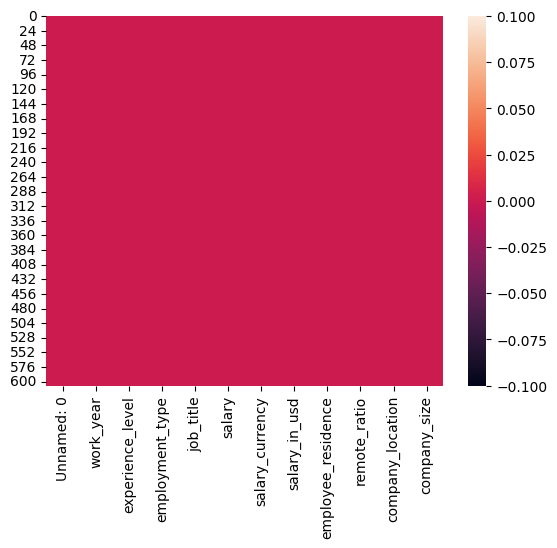

In [6]:
# Визуализация отсутствия пропусков в данных
sns.heatmap(ds_df.isnull())

In [7]:
# Проверка на наличие дубликатов
dupl = ds_df[ds_df.duplicated()].shape[0]
print(f'Количество дубликатов: {dupl}')

Количество дубликатов: 0


## Выводы по описательному анализу данных.

Согласно описательному анализу данных предложенный для исследования датасет содержит 12 колонок и 607 записей. Пропущенные значения в датасете отсутствуют, так же как и дубликаты. Стоит отметить, что датасет содержит неинформативные признаки, такие как Unnamed, salary и salary_currency. Признак Unnamed не несет в себе смысловой нагрузки и полностью бесполезен для проведения статистического анализа, поскольку представляет собой исключительно числовое порядковое представление записей датасета от 0 до 606 и подлежит дальнейшему удалению. Что касается признаков salary и salary_currency стоит отметить, что признак salary является альтернативой более информативного признака salary_in_usd и содержит информацию о заработной плате, выплаченной специалистам Data Science (далее - DS) в разной валюте. Поскольку датасет, как говорилось ранее, содержит более информативный аналог вышеуказанного признака, а именно, признак salary_in_usd, в котором заработная плата специалистов DS приведена в единую валюту, признак salary_currency подлежит удалению. Признак salary_currency также подлежит удалению, поскольку не имеет смысловой нагрузки, ввиду утраты своей актуальности, вследствие удаления признака salary.

## 1.1 Обработка данных

In [8]:
# Удаление неинформативных признаков
ds_df = ds_df.drop(columns=['Unnamed: 0','salary', 'salary_currency'])
# Получение детальной информации об обновленном датасете
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary_in_usd       607 non-null    int64 
 5   employee_residence  607 non-null    object
 6   remote_ratio        607 non-null    int64 
 7   company_location    607 non-null    object
 8   company_size        607 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.8+ KB


<Axes: >

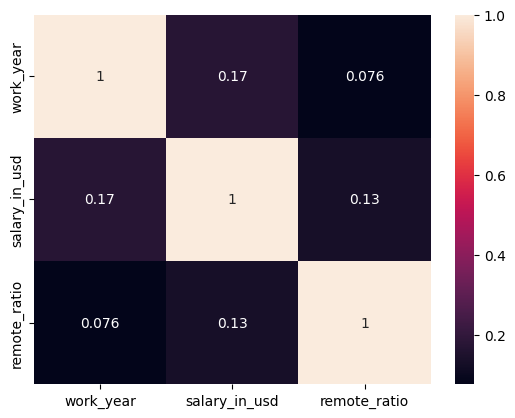

In [9]:
# Проверка статистической взаимосвязи между числовыми признаками
# Построение матрицы корреляции
sns.heatmap(ds_df.corr(numeric_only = True), annot=True)

## Вывод по обработке данных

В рамках обработки данных были удалены неинформативные признаки (Unnamed, salary и salary_currency), а также была проведена проверка на мультиколлинеарность признаков оставшихся после "отчистки" датасета. Согласно матрице корреляции между признаками, оставшимися после "отчистки" датасета, отсутствует связь или связь между ними очень мала, а следовательно в датасете нет неинформативных признаков которые из-за мультиколлинеарности подлежали бы удалению.

## 1.2 Проведение разведовательного анализа данных с помощью библиотеки ydata-profiling  

In [25]:
# Определение основных статестических характеристик прзнаков
profile = ProfileReport(ds_df, title='DS_Salaries Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Классификация признаков датасета
1. Числовые признаки:
   * salary_in_usd
2. Категориальные признаки:
   * work_year;
   * experience_level;
   * employment_type;
   * job_title;
   * employee_residence (text);
   * remote_ratio;
   * company_location;
   * company_size.


## Вывод по проведенному разведывательному анализу данных

В рамках разведывательного анализа были классифицированы признаки датасета на числовые и категориальные, а также с помощью библиотеки ydata-profiling был получен отчет, для целей обретения более детального представления о датасете.

## 2. Разведывательный анализ данных (визуализация)

Text(0.5, 1.0, 'Распределение оплаты труда специалистам DS')

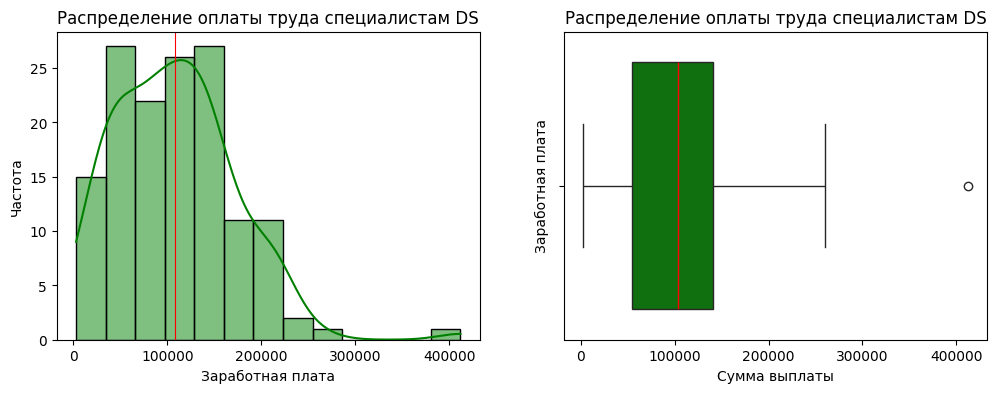

In [146]:
# Визуализация распределение оплаты труда специалистам DS
mask = ds_df[ds_df['job_title'] == 'Data Scientist']
# Построение визуализации
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(mask['salary_in_usd'], kde=True, ax=axes[0], color='green')
axes[0].set(xlabel='Заработная плата', ylabel='Частота')
axes[0].set_title('Распределение оплаты труда специалистам DS')
axes[0].axvline(mask['salary_in_usd'].mean(), color='red', linestyle='-', linewidth=0.8)

sns.boxplot(mask['salary_in_usd'], ax=axes[1], color='green', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
axes[1].set(xlabel='Сумма выплаты', ylabel='Заработная плата')
axes[1].set_title('Распределение оплаты труда специалистам DS')

In [11]:
# Статистика распределения оплаты труда специалистам DS
desc_info = mask['salary_in_usd'].describe().round(2).to_frame()
desc_info.columns = ['Статистика по заработной плате специалистов DS']
display(desc_info)

,Статистика по заработной плате специалистов DS
count,143.00
mean,108187.83
std,64112.84
min,2859.00
25%,54724.00
50%,103691.00
75%,140850.00
max,412000.00


Согласно графикам, распределение заработной платы специалистам DS отлично от нормального. Также, согласно коробчатой диаграмме в данных о заработной плате имеются выбросы (заработная плата специалиста DS составляет более 400 000,00 тыс. долларов в год). Межквартильный размах в диапазоне от 54 724,00 тыс. долларов ($Q_25$) до 140 850,00 тыс. долларов ($Q_75$), медиана - 103 691,00 тыс. долларов.      

Text(0.5, 1.0, 'Распределение оплаты труда по году выплаты зарплаты')

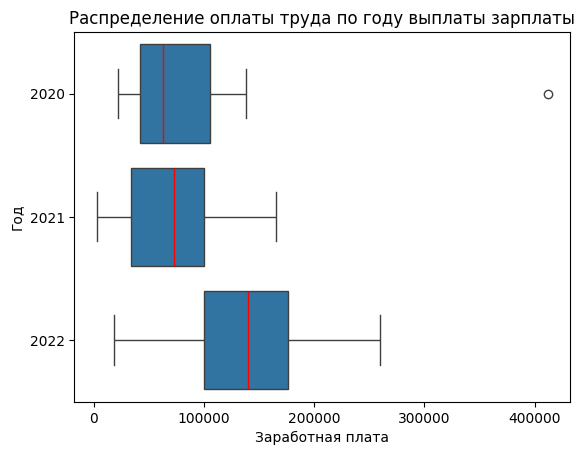

In [15]:
# Визуализация соотношения оплаты труда специалистов DS и года совершения оплаты
year_salary_box = sns.boxplot(mask, x='salary_in_usd', y='work_year', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
year_salary_box.set(xlabel='Заработная плата', ylabel='Год')
year_salary_box.set_title('Распределение оплаты труда по году выплаты зарплаты')

In [13]:
# Статистика выплаты заработной платы специалистам DS по годам
year_salary_ds = mask.groupby('work_year')['salary_in_usd'].describe().round(2)
display(year_salary_ds)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Распределение оплаты труда по году выплаты заработной платы имеет тенденцию к увеличению средних и медианных значений за период анализируемый период (с 2020 г. по 2022 г.). Для определения, являются ли эти различия статистически значимыми, необходимо провести статистические тесты.

Text(0.5, 1.0, 'Распределение оплаты труда по опыту')

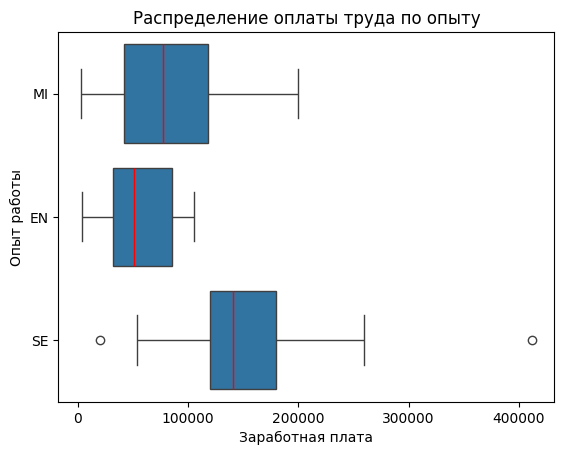

In [14]:
# Визуализация оплаты труда специалистов DS в зависимости от опыта
experience_box = sns.boxplot(mask, x='salary_in_usd', y='experience_level', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
experience_box.set(xlabel='Заработная плата', ylabel='Опыт работы')
experience_box.set_title('Распределение оплаты труда по опыту')

In [15]:
# Статистика оплаты труда специалистов DS в зависимости от опыта 
experience_salary_ds = mask.groupby('experience_level')['salary_in_usd'].describe().round(2)
display(experience_salary_ds)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Среднее значение оплаты труда специалистов DS увеличивается с опытом работы соискателя. Стоит обратить внимание, что специалистов DS занимающих в прошлом году должность Director отсутствует. Также, интересен тот факт, что минимальная заработная плата специалиста DS занимающего должность Junior на 1 141,00 тыс. долларов больше, чем того же самого специалиста, занимающего должность Intermediate (4 000,00 тыс. долларов - 2 859,00 тыс. долларов).

Text(0.5, 1.0, 'Зависимость оплаты труда от типа трудоустройства')

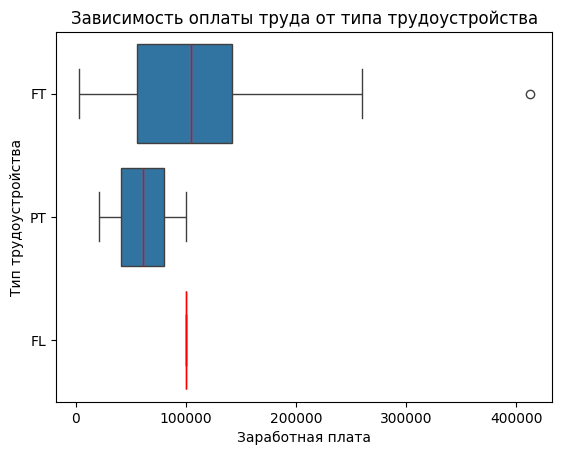

In [16]:
# Визуализация оплаты труда специалистов DS в зависимости от типа трудоустройства
employment_box = sns.boxplot(mask, x='salary_in_usd', y='employment_type', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
employment_box.set(xlabel='Заработная плата', ylabel='Тип трудоустройства')
employment_box.set_title('Зависимость оплаты труда от типа трудоустройства')

In [17]:
# Статистика оплаты труда специалистов DS в зависимости от типа трудоустройства
employment_slary_ds = mask.groupby('employment_type')['salary_in_usd'].describe().round(2)
display(employment_slary_ds)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Согласно графику, в полном большинстве, специалисты DS предпочитают тип трудоустройства - "полный рабочий день" (140 позиций).

Text(0.5, 1.0, 'Зависимость заработной платы от страны проживания')

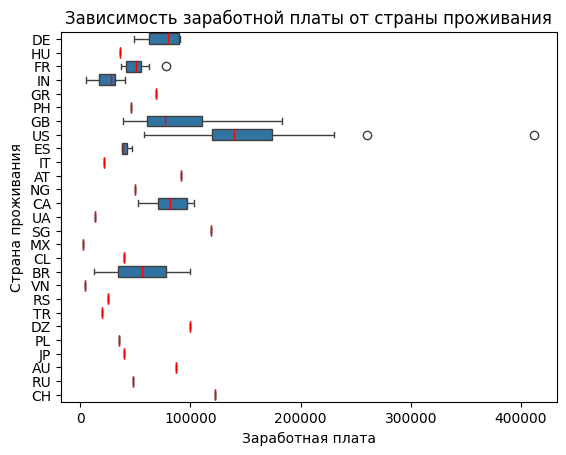

In [18]:
# Визуализация оплаты труда специолистов DS в зависимости от страны их проживания 
residence_box = sns.boxplot(mask, x='salary_in_usd', y='employee_residence', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
residence_box.set(xlabel='Заработная плата', ylabel='Страна проживания')
residence_box.set_title('Зависимость заработной платы от страны проживания')

In [19]:
# Статистика по оплате труда специолистов DS в зависимости от страны их проживания 
residence_salary_ds = mask.groupby('employee_residence')['salary_in_usd'].describe().round(2)
display(residence_salary_ds)

,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AT,1.0,91237.00,NaN,91237.0,91237.00,91237.0,91237.00,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
BR,2.0,56450.50,61588.29,12901.0,34675.75,56450.5,78225.25,100000.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0
DE,7.0,74773.71,16834.87,49268.0,62096.50,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.50,38776.0,42792.50,46809.0


Среднее значение оплаты труда значительно отличается по разным странам проживания. Преимущественно специалисты DS проживают в США (54.55% от общего числа специалистов DS).

Text(0.5, 1.0, 'Заработная плата в зависимости от работы, выполненной удаленно')

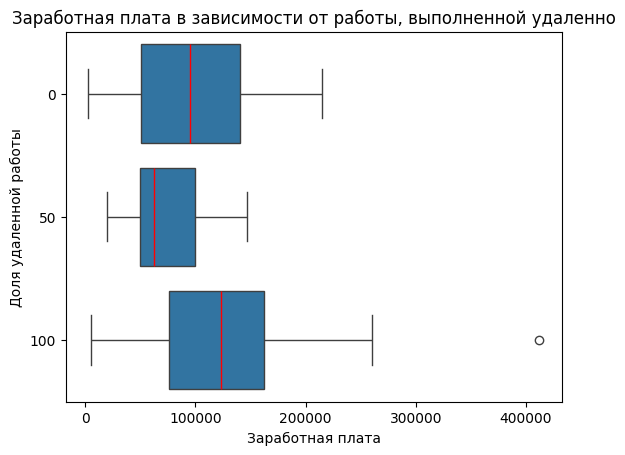

In [20]:
# Визуализация оплаты труда специалистов DS в зависимости от доли работы, выполненной удаленно 
remote_ratio_box = sns.boxplot(mask, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
remote_ratio_box.set(xlabel='Заработная плата', ylabel='Доля удаленной работы')
remote_ratio_box.set_title('Заработная плата в зависимости от работы, выполненной удаленно')

In [29]:
# Статистика по оплате труда специалистов DS в зависимости от доли работы, выполненной удаленно
remote_ratio_salary_ds = mask.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
display(remote_ratio_salary_ds)

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


Среднее значение оплаты труда значительно отличается в зависимости от доли работы, выполняемой удаленно. 

Text(0.5, 1.0, 'Заработная плата в зависимости от мостонахождения компании')

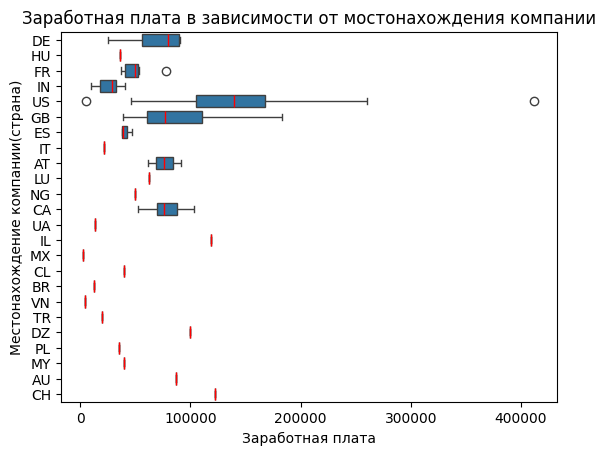

In [21]:
# Визуализация оплаты труда специолистов DS в зависимости от мостонахождения компании 
company_location_box = sns.boxplot(mask, x='salary_in_usd', y='company_location', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
company_location_box.set(xlabel='Заработная плата', ylabel='Местонахождение компании(страна)')
company_location_box.set_title('Заработная плата в зависимости от мостонахождения компании')

In [22]:
# Статистика по оплате труда специолистов DS в зависимости от мостонахождения компании
company_location_salary_ds = mask.groupby('company_location')['salary_in_usd'].describe().round(2)
display(company_location_salary_ds)

,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AT,2.0,76352.00,21050.57,61467.0,68909.5,76352.0,83794.50,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.0,86703.0,86703.00,86703.0
BR,1.0,12901.00,NaN,12901.0,12901.0,12901.0,12901.00,12901.0
CA,5.0,77787.00,19301.65,52396.0,69336.0,75774.0,87738.00,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.0,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.0,40038.0,40038.00,40038.0
DE,7.0,69640.14,25045.56,25532.0,55997.0,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.0,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.5,38776.0,42792.50,46809.0


Среднее значение оплаты труда значительно отличается по разным странам размещения головного офиса компании. Преимущественно специалисты DS работаю в компаниях находящихся в США (58.74% от общего числа специалистов DS).

Text(0.5, 1.0, 'Заработная плата в зависимости от размера компании')

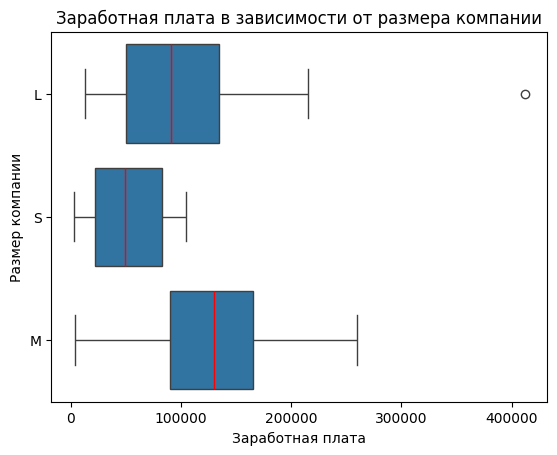

In [23]:
# Визуализация оплаты труда специалистов DS в зависимости от размера компании
company_size_box = sns.boxplot(mask, x='salary_in_usd', y='company_size', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
company_size_box.set(xlabel='Заработная плата', ylabel='Размер компании')
company_size_box.set_title('Заработная плата в зависимости от размера компании')

In [24]:
# Статистика по оплате труда специалистов DS в зависимости от размера компании
company_size_salary_ds = mask.groupby('company_size')['salary_in_usd'].describe().round(2)
display(company_size_salary_ds)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Среднее значение оплаты труда значительно отличается в зависимости от размера компании. Для определения, являются ли эти различия статистически значимыми, необходимо провести статистические тесты.

## Вывод по разведывательному анализу данных (визуализация).

На заработную плату специалиста DS в большинстве случаев, согласно проведенному анализу, влияют следующие факторы:

* *1. Фактор опыта работы;*
* *2. Фактор местонахождения компании;*
* *3. Фактор местонахождения специалиста;*
* *4. Фактор размера компании;*
* *5. Фактор типа трудоустройства.*

## 2.2 Статистический анализ данных

In [99]:
# Функция проверки нормальности распределения
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# Функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
        
# Функция проверки равенства дисперсий
def decision_dispersion(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('Дисперсии не одинаковы. В stats.ttest_ind нужно использовать параметр equal_var=False')
    else:
        print('Дисперсии одинаковы. В stats.ttest_ind нужно использовать параметр equal_var=True')

## Наблюдается ли ежегодный рост заработной платы у специалистов DS?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы у специалистов DS в 2020 г. ($μ_1$), в 2021 г. ($μ_2$) и в 2022 г. ($μ_3$) равны.

$$ H_0 : μ_1 = μ_2 = μ_3$$ 

*Альтернативная гипотеза* ($H_1$): размер заработной платы у специалистов DS в 2020 г. ($μ_1$), меньше чем в 2021 г. ($μ_2$), а в 2021 году ($μ_2$) меньше чем и в 2022 г. ($μ_3$), то есть размер заработной платы увеличивается от года к году. 

$$ H_1 : μ_1 < μ_2 < μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. 

Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [51]:
# Заработная плата специалистов DS в 2020 году
salary_ds_2020 = list(ds_df.loc[(ds_df['work_year'] == 2020) & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Заработная плата специалистов DS в 2021 году
salary_ds_2021 = list(ds_df.loc[(ds_df['work_year'] == 2021) & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Заработная плата специалистов DS в 2022 году
salary_ds_2022 = list(ds_df.loc[(ds_df['work_year'] == 2022) & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Тест Шапиро-Уилка
print('Для зарплаты DS в 2020 году:')
result = stats.shapiro(salary_ds_2020)
decision_normality(result[1])

print('\nДля зарплаты DS в 2021 году:')
result = stats.shapiro(salary_ds_2021)
decision_normality(result[1])

print('\nДля зарплаты DS в 2022 году:')
result = stats.shapiro(salary_ds_2022)
decision_normality(result[1])


Для зарплаты DS в 2020 году:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для зарплаты DS в 2021 году:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для зарплаты DS в 2022 году:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выбор подходящего статистического теста**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Да.
* Признак распределён по нормальному закону? — Нет.

Для проверки гипотезы, можно использовать Критерий Фридмана для сравнения распределений на основе рангов.


In [52]:
# Критерий Фридмана
_, p = stats.friedmanchisquare(salary_ds_2020, salary_ds_2021[:21], salary_ds_2022[:21])
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод по вопросу* - размер заработной платы у специалистов DS увеличивается от года к году.   

## Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы у специалистов DS в 2022 г. ($μ_1$) и у специалистов DE в 2022 г. ($μ_2$) равны.

$$ H_0 : μ_1 = μ_2$$ 

*Альтернативная гипотеза* ($H_1$): размер заработной платы у специалистов DS в 2022 г. ($μ_1$) и у специалистов DE в 2022 г. ($μ_2$) не равны.

$$ H_1 : μ_1 \neq μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. 

Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [58]:
# Заработная плата специалистов DE в 2022 году
salary_de_2022 = list(ds_df.loc[(ds_df['work_year'] == 2022) & (ds_df['job_title'] == 'Data Engineer'), 'salary_in_usd'])
# Тест Шапиро-Уилка
print('Для зарплаты DS в 2022 году:')
result = stats.shapiro(salary_ds_2022)
decision_normality(result[1])

print('\nДля зарплаты DE в 2022 году:')
result = stats.shapiro(salary_de_2022)
decision_normality(result[1])



Для зарплаты DS в 2022 году:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для зарплаты DE в 2022 году:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

In [60]:
# U-критерий Манна — Уитни 
_, p = stats.mannwhitneyu(salary_ds_2022, salary_de_2022[:77])
decision_hypothesis(p)

p-value = 0.123
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


*Вывод по вопросу* - размер заработной платы у специалистов DS в 2022 г. и у специалистов DE в 2022 г. равны. 

## Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размеры заработной платы у специалистов DS в небольшой компании ($μ_1$), в средней компании ($μ_2$) и в крупной компании ($μ_3$) равны.

$$ H_0 : μ_1 = μ_2 = μ_3$$ 

*Альтернативная гипотеза* ($H_1$): размеры заработной платы у специалистов DS в небольшой компании ($μ_1$), в средней компании ($μ_2$) и в крупной компании ($μ_3$) не равны.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. 

Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [87]:
# Заработная плата специалистов DS в небольшой компании
salary_ds_s = list(ds_df.loc[(ds_df['company_size'] == 'S') & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Заработная плата специалистов DS в средней компании
salary_ds_m = list(ds_df.loc[(ds_df['company_size'] == 'M') & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Заработная плата специалистов DS в крупной компании
salary_ds_l = list(ds_df.loc[(ds_df['company_size'] == 'L') & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Тест Шапиро-Уилка
print('Для зарплаты DS небольшоей компании:')
result = stats.shapiro(salary_ds_s)
decision_normality(result[1])

print('\nДля зарплаты DS в средней компании:')
result = stats.shapiro(salary_ds_m)
decision_normality(result[1])

print('\nДля зарплаты DS в крупной компании:')
result = stats.shapiro(salary_ds_l)
decision_normality(result[1])

Для зарплаты DS небольшоей компании:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для зарплаты DS в средней компании:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для зарплаты DS в крупной компании:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Среднее количество людей, работавших в компании»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.


In [71]:
# Критерий Краскела — Уоллиса
_, p = stats.kruskal(salary_ds_s, salary_ds_m[:21], salary_ds_l[:21])
decision_hypothesis(p)

p-value = 0.048
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод по вопросу* - размеры заработной платы у специалистов DS в небольшой компании, в средней компании и в крупной компании не равны.

## Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): между тем, занимает ли специалист должность DS или DE и размером компании, в которой специалист работает нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза* ($H_1$): между тем, занимает ли специалист должность DS или DE и размером компании, в которой специалист работает есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Роль, в которой соискатель работал в течение года»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

In [85]:
# Фильтрация исходыого датафрейма
filt = ds_df[ds_df['job_title'].isin(['Data Scientist', 'Data Engineer'])]
# Таблица сопряженности
cross_table = pd.crosstab(filt['job_title'], filt['company_size'])
cross_table


company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [86]:
# Критерий хи-квадрат
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


*Вывод по вопросу* - между тем, занимает ли специалист должность DS или DE и размером компании, в которой специалист работает есть взаимосвязь (признаки зависимы).

## 3.Дополнительное исследование 

## Как соотносятся зарплаты специалистов Data Scientist в зависимости от объема работы, выполняемой удалённо?


*Визуализация приведена в разделе  "2. Разведывательный анализ данных" - график № 6* 

*Нулевая гипотеза* ($H_0$): размеры заработной платы у специалистов DS не работающих удаленно (удаленная работа менее 20%) ($μ_1$), частично работающих удаленно ($μ_2$) и полностью работающих удаленно ($μ_3$) равны.

$$ H_0 : μ_1 = μ_2 = μ_3$$ 

*Альтернативная гипотеза* ($H_1$): размеры заработной платы у специалистов DS не работающих удаленно (удаленная работа менее 20%) ($μ_1$), частично работающих удаленно ($μ_2$) и полностью работающих удаленно ($μ_3$) не равны.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. 

Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [122]:
# Заработная плата специалистов DS не работающий удаленно 
salary_ds_0 = list(ds_df.loc[(ds_df['remote_ratio'] == 0) & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Заработная плата специалистов DS частично работающих удаленно
salary_ds_50 = list(ds_df.loc[(ds_df['remote_ratio'] == 50) & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Заработная плата специалистов DS полностью работающих
salary_ds_100 = list(ds_df.loc[(ds_df['remote_ratio'] == 100) & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Тест Шапиро-Уилка
print('Для зарплаты DS небольшоей компании:')
result = stats.shapiro(salary_ds_0)
decision_normality(result[1])

print('\nДля зарплаты DS в средней компании:')
result = stats.shapiro(salary_ds_50)
decision_normality(result[1])

print('\nДля зарплаты DS в крупной компании:')
result = stats.shapiro(salary_ds_100)
decision_normality(result[1])

Для зарплаты DS небольшоей компании:
p-value = 0.363
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для зарплаты DS в средней компании:
p-value = 0.482
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для зарплаты DS в крупной компании:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Среднее количество людей, работавших в компании»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [92]:
# Критерий Краскела — Уоллиса
_, p = stats.kruskal(salary_ds_0[:25], salary_ds_50, salary_ds_100[:25])
decision_hypothesis(p)

p-value = 0.606
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


*Вывод по вопросу* - размеры заработной платы у специалистов DS не работающих удаленно (удаленная работа менее 20%), частично работающих удаленно и полностью работающих удаленно равны. 

## Больше ли заработная платы у специалистов DS работающих на должности Junior чем и у специалистов DE работающих на должности Junior?


Text(0.5, 1.0, 'Распределение оплаты труда специалистов DS и DE \nработающих на должности Junior')

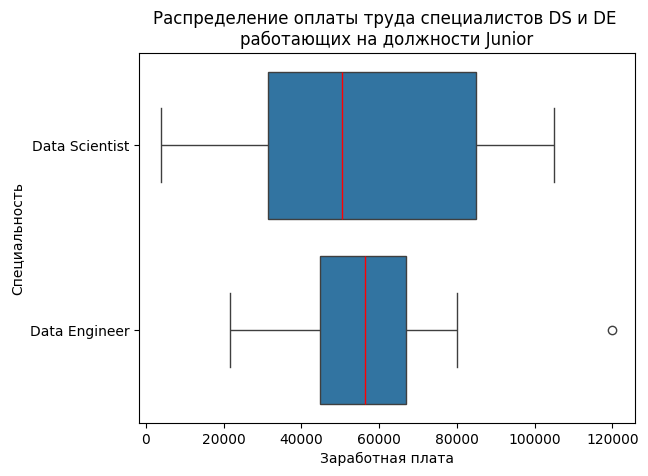

In [150]:
# Визуализация
mask_2 = filt[filt['experience_level'] == 'EN']
ds_de_box = sns.boxplot(mask_2, x='salary_in_usd', y='job_title', orient='h', medianprops={'color': 'red', 'linestyle': '-'})
ds_de_box.set(xlabel='Заработная плата', ylabel='Специальность')
ds_de_box.set_title('Распределение оплаты труда специалистов DS и DE \nработающих на должности Junior')


In [151]:
ds_de_salary = mask_2.groupby('job_title')['salary_in_usd'].describe().round()
display(ds_de_salary)

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,12.0,58934.0,25523.0,21637.0,44778.0,56388.0,66885.0,120000.0
Data Scientist,22.0,55331.0,31238.0,4000.0,31474.0,50484.0,85027.0,105000.0


Согласно коробчатой диаграмме у специалистов DE занимающих должность Junior присутствует выброс в данных (заработная плата начинающего специалиста 120 000,00 тыс. долларов в год). Также, весма существенна разница между минимальным значением заработной платы начинающего специалиста DS (4 000,00 тыс. долларов) и специалиста DE (21 637,00 тыс. долларов). Настоящая разница составляет 17 637,00 тыс. долларов.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы у специалистов DS работающих на должности Junior ($μ_1$) равнен заработной плате специалистов DE работающих на должности Junior ($μ_2$).

$$ H_0 : μ_1 = μ_2$$ 

*Альтернативная гипотеза* ($H_1$): размер заработной платы у специалистов DS работающих на должности Junior ($μ_1$) больше чем и у специалистов DE работающих на должности Junior ($μ_2$).

$$ H_1 : μ_1 = μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределены ли признаки нормально. 

Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [134]:
# Заработная плата специалистов DS на должности Junior 
salary_ds_en = list(ds_df.loc[(ds_df['experience_level'] == 'EN') & (ds_df['job_title'] == 'Data Scientist'), 'salary_in_usd'])
# Заработная плата специалистов DE на должности Junior
salary_de_en = list(ds_df.loc[(ds_df['experience_level'] == 'EN') & (ds_df['job_title'] == 'Data Engineer'), 'salary_in_usd'])

# Тест Шапиро-Уилка
print('Для зарплаты DS работающих на должности Junior:')
result = stats.shapiro(salary_ds_en)
decision_normality(result[1])

print('\nДля зарплаты DE работающих на должности Junior:')
result = stats.shapiro(salary_de_en)
decision_normality(result[1])


Для зарплаты DS работающих на должности Junior:
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для зарплаты DE работающих на должности Junior:
p-value = 0.443
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да. 

Для проверки нашей гипотезы можно использовать двухпарный Т-критерий.

In [136]:
# Тест на равенство дисперсий
result = stats.levene(salary_ds_en[:12], salary_de_en)
p = result[1]
decision_dispersion(p)

p-value = 0.413
Дисперсии одинаковы. В stats.ttest_ind нужно использовать параметр equal_var=True


In [135]:
#Двухпарный Т-критерий
_, p = stats.ttest_ind(salary_ds_en[:12], salary_de_en, alternative='greater', equal_var=True)
decision_hypothesis(p)


p-value = 0.757
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


*Вывод по вопросу* - размер заработной платы у специалистов DS работающих на должности Junior равнен заработной плате специалистов DE работающих на должности Junior.